<a href="https://colab.research.google.com/github/Gyuseo-stack/Statistics_DGS/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

In [ ]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv("/content/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541909, 8)

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


데이터 파일의 첫 번째 항목을 보면 고객 ID 17850(영국) 고객이 송장 번호 536365로 한 번의 주문을 했음을 알 수 있다.
이 주문에는 여러 상품이 포함돼 있으며 각 상품은 다른 재고 코드(StockCode), 상품 설명, 단가(Unit Price), 수량(Quantity)을 가진다.
또한 이 상품들은 모두 같은 날짜(InvoiceDate)**에 주문되었다

In [ ]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


전체 고객 중 약 25%의 고객 ID가 누락되어 있으며, 상품 설명도 약 0.2%가 비어 있음.

→ 데이터가 다소 불완전하고 품질이 떨어진다는 점을 보여준다.

In [ ]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [ ]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

,count
CustomerID,
True,1454


In [ ]:
data[data.Description.isnull()].UnitPrice.value_counts()

,count
UnitPrice,
0.0,1454


설명이 누락된 경우에는 고객 정보와 단가(Unit Price)도 함께 빠져 있음.

→ 소매업체가 이런 거래를 체계적으로 기록·관리하지 않은 것으로 보이며,

→ 데이터에 이상하거나 탐지하기 어려운 값이 존재할 가능성을 시사한다.

In [ ]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


 고객 ID가 없는 거래는 **가격과 수량에서 극단치**가 나타날 수 있어,

→ 향후 가격·판매량 기반의 피처 생성 시 큰 방해 요소가 된다.

→ 따라서 소매업체는 이상하거나 특수한 거래를 처리할 전략을 마련해야 한다.

또한 **고객 ID 없이 거래가 가능한 이유**를 규명할 필요가 있으며,

→ 예를 들어 게스트 구매라면 게스트임을 표시하는 전용 ID를 부여하는 것이 바람직하다.

---
#### 숨겨진 결측치가 있는지 탐색하려는 단계

In [ ]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

,count
lowercase_descriptions,
False,539724
True,731


#### data.Description.isnull()==False
Description 컬럼에서 진짜 NaN(결측치)이 아닌 행만 고름

#### data.loc[조건, "lowercase_descriptions"] = ...
그 행들의 "lowercase_descriptions" 컬럼에 값을 채움.
#### .apply(lambda l: l.lower())
Description의 실제 텍스트를 모두 소문자로 바꿈

나중에 "nan" 이라는 글자를 찾을 때 대소문자 차이 없이 찾기 위해
→ 즉, "NaN", "NAN" 같은 변형도 모두 "nan" 으로 바꿔 비교하려는 것.

일부 데이터는 진짜 NaN 값이 아니라 "nan"이라는 텍스트가 적혀 있을 수 있음
겉보기에 값이 있는 것처럼 보여도 실제로는 결측치를 의미하는 잘못된 값

설명(Description) 컬럼에 빈 문자열("")이 존재하는지 확인해

값이 비어 있는 숨은 결측치가 있는지 점검하려는 단계

In [ ]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

,count
lowercase_descriptions,
False,540455


'NaN' 값 대신 **문자열 nan**으로 표기된 숨겨진 결측치가 추가로 발견되었음.
### 이를 진짜 NaN 값으로 변환해야 한다.

In [ ]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

고객 정보나 상품 설명이 누락된 이유를 알 수 없고, 수량·가격에서 이상치와 0원 가격도 발견되었으므로

→ **안전하게 해당 모든 레코드를 삭제**(drop) 하기로 결정

In [ ]:

data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

In [ ]:
data.isnull().sum().sum()

0

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

데이터가 수집된 전체 기간은 373일

In [ ]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


데이터 수집 기간은 왜 확인한거임??

데이터셋의 시작일과 종료일 출력

In [ ]:
data.InvoiceNo.nunique()

22186

중복을 제외한 송장 번호(InvoiceNo)의 개수,
#### 즉 서로 다른 주문 건수

데이터 설명에 따르면 취소된 거래의 송장 번호(InvoiceNo)는 앞에 'C'가 붙음.

→ 이를 쉽게 필터링하기 위해 취소 여부를 나타내는 새 컬럼(피처)을 생성

In [ ]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

,count
IsCancelled,
False,97.81007
True,2.18993


#### 전체 거래 중 약 2.2%가 취소된 주문이다

In [ ]:
data.loc[data.IsCancelled==True].describe()

,Quantity,InvoiceDate,UnitPrice
count,8896.000000,8896,8896.000000
mean,-30.882981,2011-06-27 06:10:27.308902912,18.862815
min,-80995.000000,2010-12-01 09:41:00,0.010000
25%,-6.000000,2011-03-22 16:07:00,1.450000
50%,-2.000000,2011-07-11 13:51:00,2.950000
75%,-1.000000,2011-10-06 20:36:00,4.950000
max,-1.000000,2011-12-09 11:58:00,38970.000000
std,1170.746458,NaN,444.590459


취소된 거래는 수량(Quantity)이 음수이고

**단가는 양수(0 아님)**로 나타남.

→ 하지만 취소 사유를 파악할 수 없고, 예측하기도 어렵기 때문에

→ 이러한 **취소된 거래들을 모두 삭제**하기로 결정.

---
이커머스 시장에서 결제 취소된 상품은 정확한 재고 파악을 위해서 마이너스 수량으로 재고를 되돌리는 방식으로 기록하는 경우 많음
때문에 정상적인 방식이며,
이커머스 시장에서 구매 취소율은 중요한 지표이기 때문에 단순 삭제는 ㄴㄴ
때문에 순매출, 반품율을 따로 나눠서 후에 분석에 사용해야 하지 않았을까

In [ ]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

#### 서로 다른 상품 코드(StockCode) 파악

In [ ]:
data.StockCode.nunique()

3663

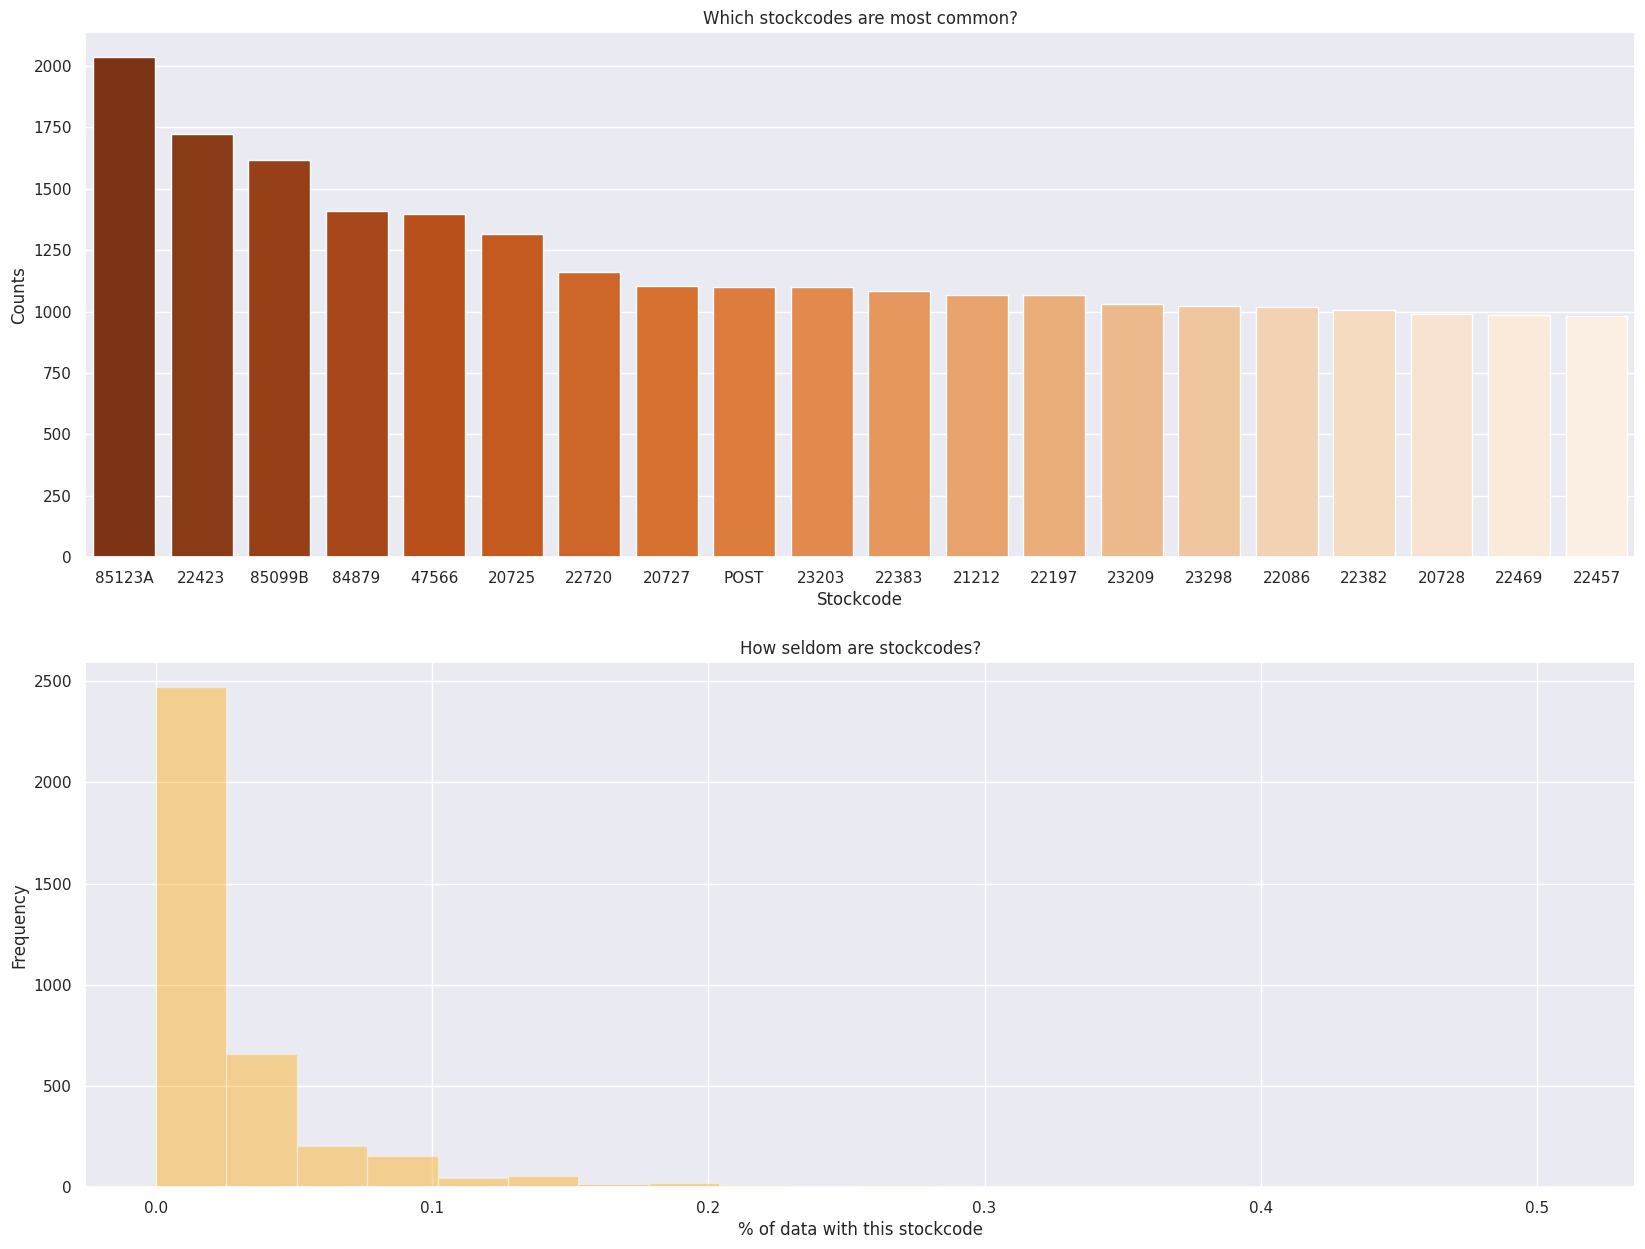

In [ ]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

가장 많이 등장한 StockCode 중 **POST**라는 특이한 코드가 발견되었는데,

→ 길이가 짧고 숫자가 아니어서 다른 코드들과 다르다.

이를 통해 상품 설명·고객 ID뿐만 아니라 **StockCode에도 이상치가 존재할 수 있음을 알 수 있다.**


또한 대부분의 StockCode는 아주 드물게 등장하는데,

→ 이는 판매되는 상품 종류가 매우 다양함을 보여준다.
하지만 이는 곧바로 특정 제품군에 대한 비전문성을 의미하지는 않음

ex) 물병처럼 같은 유형의 상품이라도 색상·이름·모양이 다양하면 서로 다른 StockCode를 가질 수 있기 때문이다.

#### StockCode(상품 코드) 안에 포함된 숫자 문자 개수와 문자열 전체 길이를 계산

In [ ]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

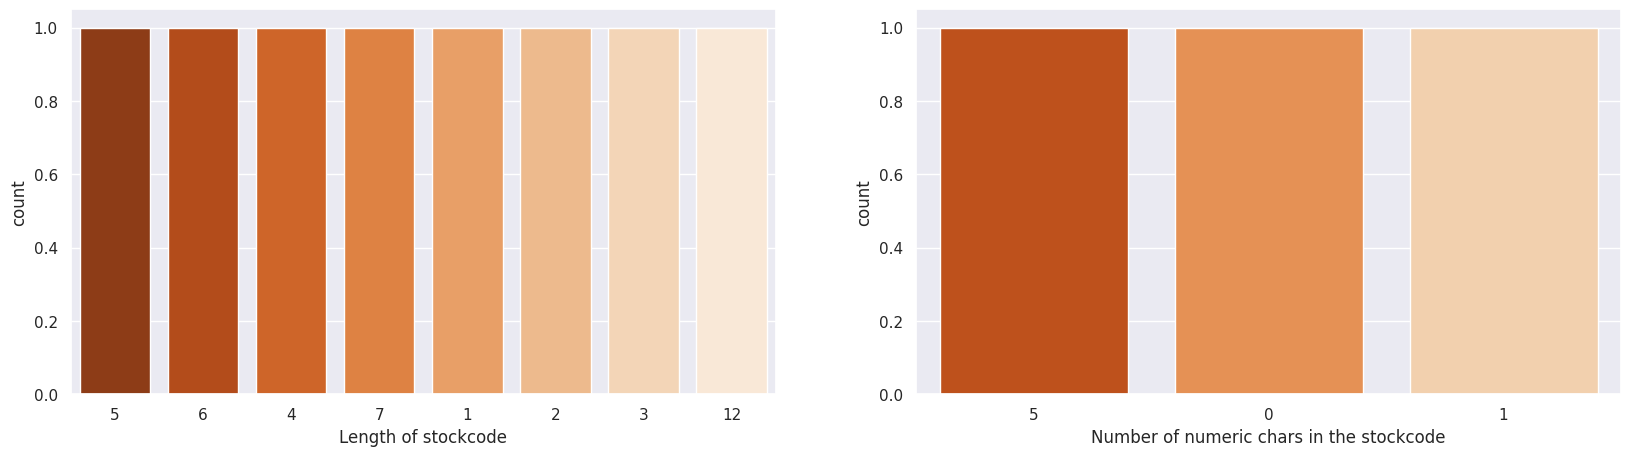

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data["StockCodeLength"], palette="Oranges_r", ax=ax[0], order = data['StockCodeLength'].value_counts().index[:10])
sns.countplot(data["nNumericStockCode"], palette="Oranges_r", ax=ax[1], order = data['nNumericStockCode'].value_counts().index[:10])
ax[0].set_xlabel("Length of stockcode")
ax[1].set_xlabel("Number of numeric chars in the stockcode");

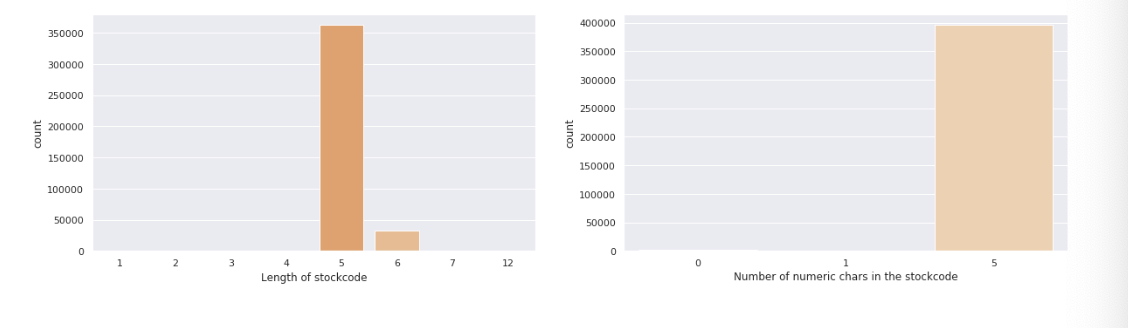

대부분의 상품 코드(StockCode)는 5자리 숫자로 구성돼 있지만,예외적인 경우도 존재한다.

**길이**: 1자리에서 12자리까지 다양함

**숫자 없음**: 숫자가 전혀 포함되지 않은 코드도 있음

즉, **StockCode가 일관된 형식을 따르지 않아 데이터 처리 시 주의가 필요**

In [ ]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

,count
lowercase_descriptions,
postage,1099
manual,290
carriage,133
dotcom postage,16
bank charges,12
pads to match all cushions,4


특수 거래와 정상적인 고객 거래를 명확히 구분하지 않은 데이터가 또 발견되었음.

→ 예측 모델에서 불필요하거나 왜곡을 줄 수 있는 데이터이므로

→ 이런 거래들을 모두 제거(drop) 하기로 결정

????

In [ ]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()

2783

In [ ]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

In [ ]:
data.Description.nunique()

2983

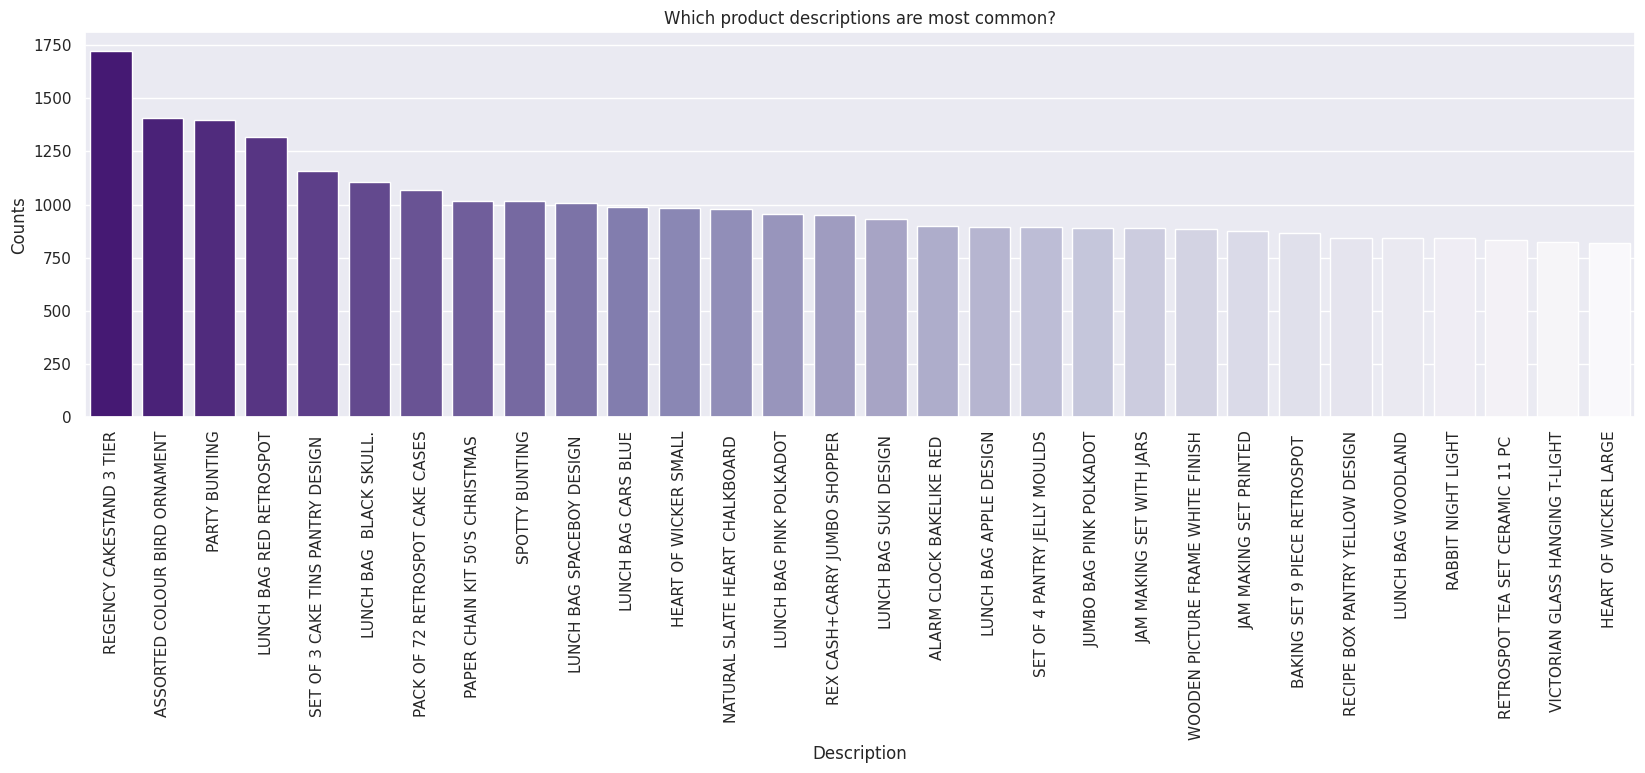

In [ ]:
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

데이터를 살펴보면 유사한 제품군을 나타내는 설명들이 존재함

- 예: Lunch bag(도시락 가방)처럼 **색상만 다른 비슷한 제품**이 여러 번 등장.
- 가장 자주 등장하는 설명들을 보면 매우 다양한 종류의 상품을 판매하고 있음을 확인할 수 있음.
- 또한 모든 상품 설명이 **대문자(uppercase) 로만 작성**돼 있음.

→ 그래서 다음 단계로, 설명(Description) 문자열의 길이와 소문자(lowercase) 문자 수를 세어
텍스트 패턴을 추가로 분석하려고 한다는 의미입니다.

In [ ]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [ ]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(data.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

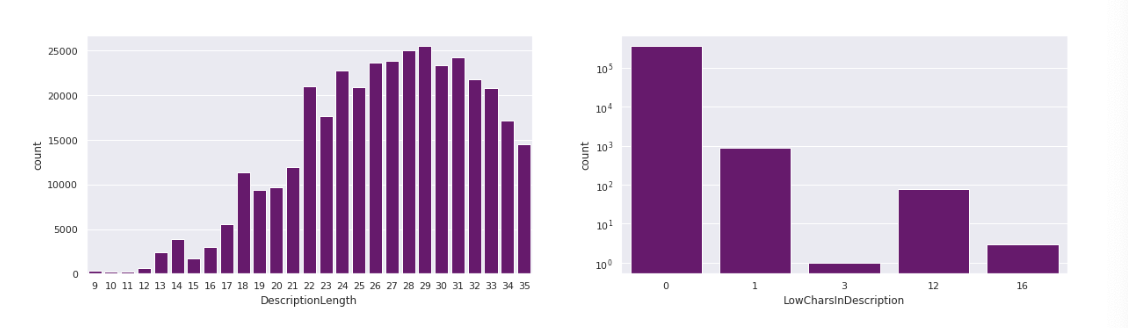

대부분의 상품 설명(Description)에는 소문자 문자가 전혀 없지만,

→ 일부 예외적으로 소문자가 포함된 경우가 발견

In [ ]:
lowchar_counts = data.loc[data.LowCharsInDescription > 0].Description.value_counts()

plt.figure(figsize=(15,3))
sns.barplot(x=lowchar_counts.index, y=lowchar_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

상품 설명 중
**“Next day carriage”**
와 **"high resolution image”** 처럼

→ 다른 항목과 달리 **소문자가 포함된 특이한 설명이 발견**

이에 따라 설명 전체에서 대문자 대비 소문자의 비율(lowercase/uppercase)을 계산해
→ 이런 특이한 항목들을 정량적으로 파악

In [ ]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [ ]:
data.UpCharsInDescription.describe()

In [ ]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

In [ ]:
data = data.loc[data.UpCharsInDescription > 5].copy()

#### 상품 설명(Description) 중에서 문자 길이가 14자 미만인 항목

In [ ]:
dlength_counts = data.loc[data.DescriptionLength < 14].Description.value_counts()

plt.figure(figsize=(20,5))
sns.barplot(dlength_counts.index, dlength_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

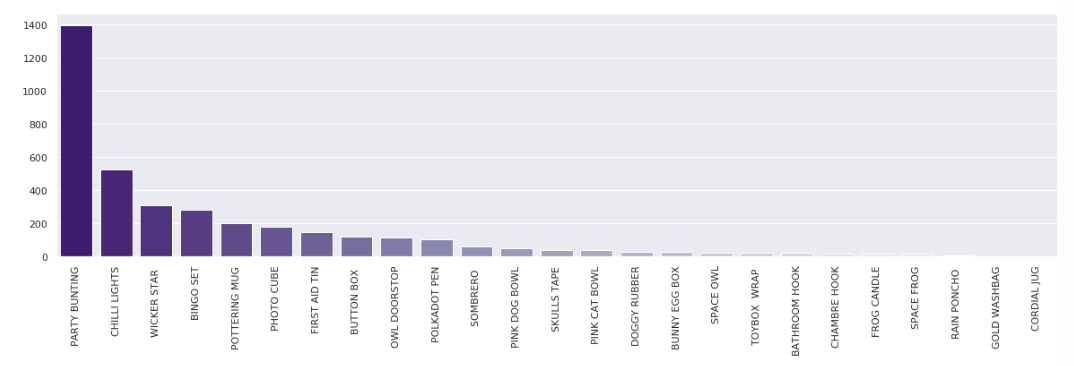

데이터셋에서

고유한 상품 코드(StockCode) 가 몇 개인지,

고유한 상품 설명(Description) 이 몇 개인지

→ 각각의 중복되지 않는(unique) 값의 개수를 확인

In [ ]:
data.StockCode.nunique()

In [ ]:
data.Description.nunique()

상품 설명(Description) 의 고유 개수가 StockCode(상품 코드) 의 고유 개수보다 더 많다는 것은,

**하나의 상품 코드가 여러 다른 설명으로 기록된 경우가 있다는 뜻**

In [ ]:
data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

,Description
StockCode,
23236,4
23196,4
22937,3
23131,3
23413,3
23209,3
23396,3
23203,3
23535,3


In [ ]:
data.loc[data.StockCode == "23244"].Description.value_counts()

,count
Description,
ROUND STORAGE TIN VINTAGE LEAF,96
STORAGE TIN VINTAGE LEAF,7
CANNISTER VINTAGE LEAF DESIGN,2


데이터를 직접 살펴본 결과, 동일한 상품 코드(StockCode)인데도 설명(Description)이 약간씩 다르게 기록된 경우가 있음을 확인

In [ ]:
data.CustomerID.nunique()

4315

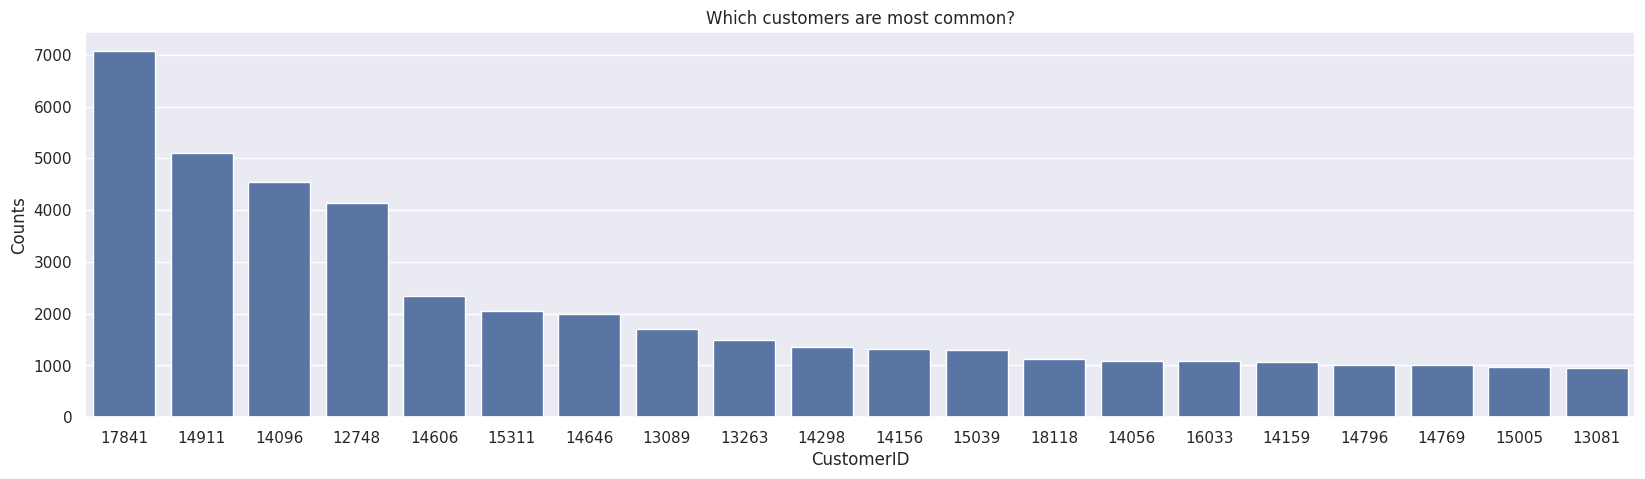

In [ ]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=customer_counts.index, y=customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

In [ ]:
data.Country.nunique()

37

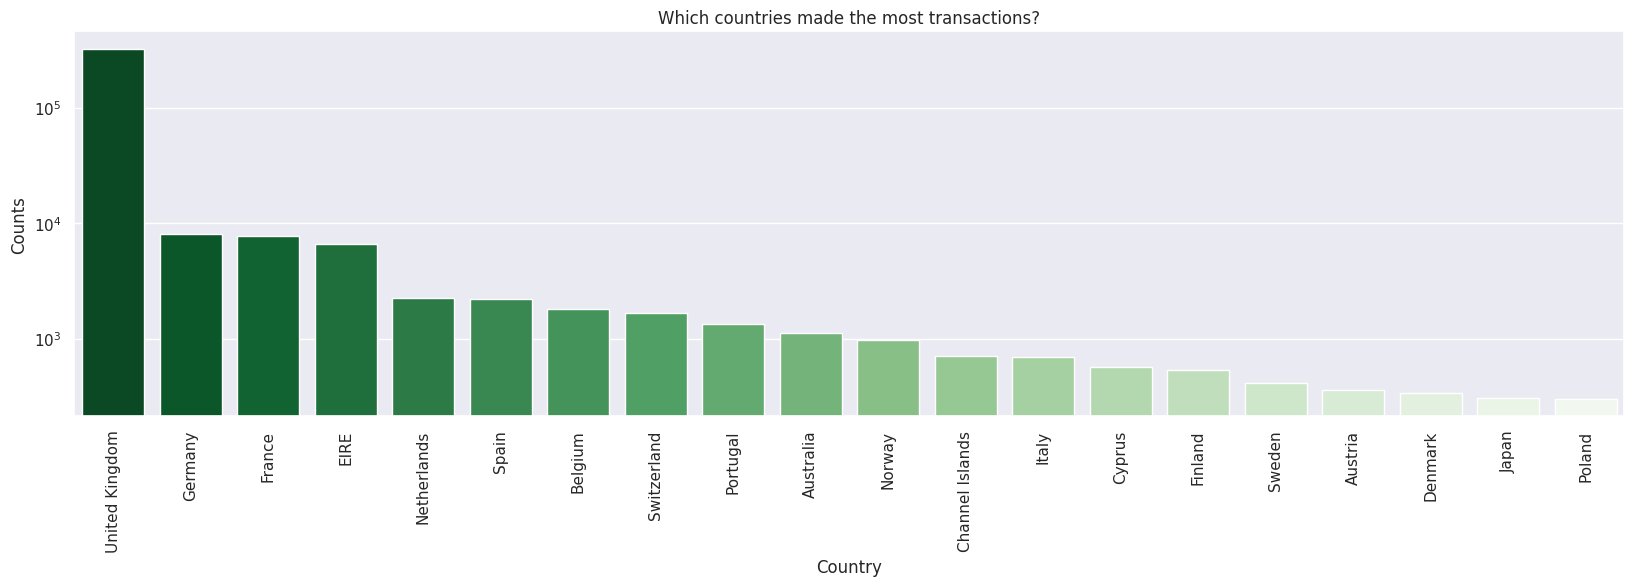

In [ ]:
country_counts = data.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

#### 영국(UK)에서 발생한 거래가 전체에서 차지하는 비율

In [ ]:
data.loc[data.Country=="United Kingdom"].shape[0] / data.shape[0] * 100

89.10192031784572

영국 내/외 거래를 구분하는 **피처** 생성

왜 구분하는지

In [ ]:
data["UK"] = np.where(data.Country == "United Kingdom", 1, 0)

In [ ]:
data.UnitPrice.describe()

,UnitPrice
count,37308.000000
mean,6.230193
std,148.693371
min,0.000000
25%,1.280000
50%,2.510000
75%,4.250000
max,13541.330000


In [ ]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,UK
30364,538861,22444,NaN,460,12/14/2010 14:04,0.0,NaN,United Kingdom,0.0,1
22295,538160,20956,NaN,288,12/9/2010 17:18,0.0,NaN,United Kingdom,0.0,1
20037,538004,22114,NaN,144,12/9/2010 12:11,0.0,NaN,United Kingdom,0.0,1
13263,537430,85215,NaN,120,12/6/2010 16:05,0.0,NaN,United Kingdom,0.0,1
7191,536999,21421,NaN,110,12/3/2010 15:32,0.0,NaN,United Kingdom,0.0,1


In [ ]:
data = data.loc[data.UnitPrice > 0].copy()

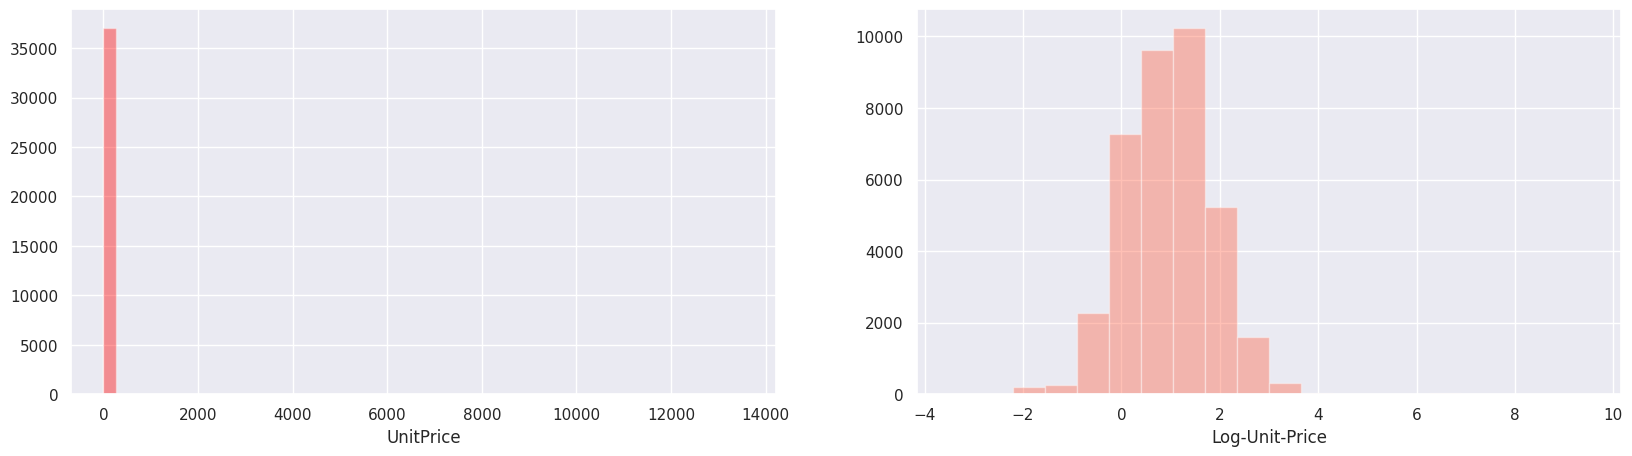

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.UnitPrice, ax=ax[0], kde=False, color="red")
sns.distplot(np.log(data.UnitPrice), ax=ax[1], bins=20, color="tomato", kde=False)
ax[1].set_xlabel("Log-Unit-Price");

In [ ]:
np.exp(-2)

np.float64(0.1353352832366127)

In [ ]:
np.exp(3)

np.float64(20.085536923187668)

In [ ]:
np.quantile(data.UnitPrice, 0.95)

np.float64(11.02)

이상적으로 높은 가격대 제품을 제외

→ 일반적인 가격대의 거래만 대상으로 예측 모델을 시작해,분석을 단순화하고 초기 모델의 안정성을 높임

In [ ]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()

In [ ]:
data.Quantity.describe()

,Quantity
count,36692.000000
mean,8.400005
std,37.325439
min,-500.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,2880.000000


대부분의 상품은 1~12개 단위로 판매

→ 이 범위를 벗어나는 극단적이고 비현실적인 수량(Quantity) 값이 발견

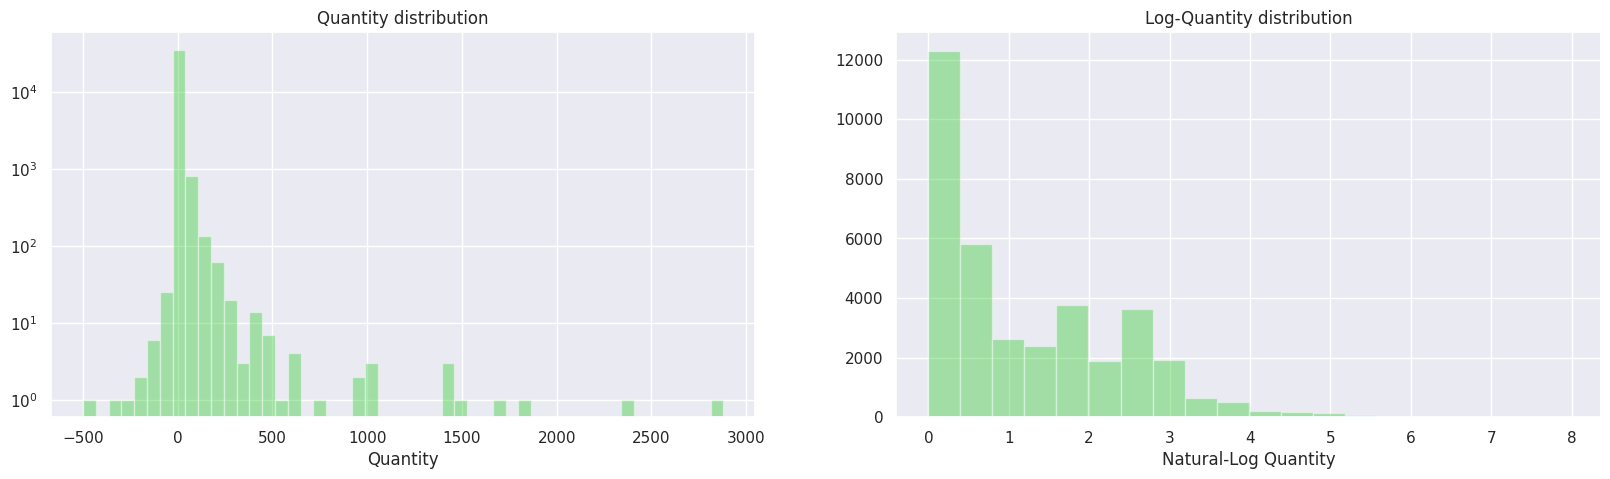

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

로그 변환된 분포(log-transformed distribution)를 살펴보니

특정 값에서 경계(cut)를 두어 이상치를 잘라내는 것이 합리적

In [ ]:
np.exp(4)

np.float64(54.598150033144236)

In [ ]:
np.quantile(data.Quantity, 0.95)

np.float64(24.0)

이렇게 기준값을 설정하면
→ 전체 데이터의 95% 이상을 여전히 포함

In [ ]:
data = data.loc[data.Quantity < 55].copy()

### 결론 및 다음 단계

#### 필요 작업

1. InvoiceDate에서 날짜·시간 관련 피처(예: 연도, 월, 일, 요일 등)를 추출해 일 단위 집계를 수행.

2. UnitPrice × Quantity를 이용해 거래별 매출(Revenue) 을 계산.

> 즉, 거래 데이터를 일별 판매 데이터로 집계하고, 매출까지 계산해야 이후 일별 판매량 예측 모델을 구축할 수 있다는 의미


In [ ]:
data["Revenue"] = data.Quantity * data.UnitPrice

data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate)
data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.isocalendar().week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [ ]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,10135,1,2.51
4,2010-12-01,2010,4,12,48,2,335,1,11001,3,10.08


일별 상품 판매량 예측을 위해

각 상품 코드(StockCode)별로 하루 동안 판매된 수량(Quantity)을 합산


In [ ]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

이 단계에서 일별·상품별 판매량을 집계하면
고객 정보, 국가 정보, 가격(UnitPrice) 같은 세부 데이터는 일시적으로 손실

이후 분석 과정에서 다시 복원(merge)하거나 재활용할 계획

In [ ]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,10135,1,2.51
4,2010-12-01,2010,4,12,48,2,335,1,11001,3,10.08


In [ ]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print(f"Quantity - Lower bound: {low_quantity}, Upper bound: {high_quantity}")

low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print(f"Revenue - Lower bound: {low_revenue}, Upper bound: {high_revenue}")

samples = daily_data.shape[0]

daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

print(f"Number of samples removed: {samples - daily_data.shape[0]}")

Quantity - Lower bound: -1.0, Upper bound: 96.0
Revenue - Lower bound: -1.95, Upper bound: 275.74079999999935
Number of samples removed: 437


In [ ]:
daily_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,16416.000000,16416.000000
mean,11.133711,25.229287
std,14.897770,35.528037
min,-1.000000,-1.950000
25%,2.000000,5.020000
50%,5.000000,12.675000
75%,14.000000,30.000000
max,96.000000,274.270000


타깃 변수(예: 일별 판매량)의

최소·최대값을 확인해 보니 극단적인 이상치가 존재

→ 이 값을 예측 모델의 타깃으로 그대로 사용하면 검증(Validation) 결과를 왜곡

Early Stopping 적용 시 모델 학습에 직접적인 악영향

> **극단치를 제거하거나 제외한 후에 타깃 변수를 사용**해야
모델의 안정적 학습과 정확한 검증이 가능

In [ ]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(np.float64(1.0), np.float64(71.85000000000036))


In [ ]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(np.float64(0.84), np.float64(190.0125000000001))


데이터의 타깃 변수에서 상·하위 극단값(이상치) 을 제거

 전체 데이터 중 90%가 포함되는 구간만 남기자는 전략을 사용

- 목적: 간단히 중간 90% 구간을 사용해 극단치가 모델 성능을 왜곡하는 것을 방지.

- 주의점: 나머지 10% 데이터를 제외함으로써 일부 중요한 정보가 손실될 수 있음.

- 추천: 단순히 제거하는 것에서 그치지 말고, 이상치를 유발한 원인을 파악·분석하는 것도 가치가 있다.

---
#### 손실된 데이터 개수

In [ ]:
samples = daily_data.shape[0]

In [ ]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

In [ ]:
samples - daily_data.shape[0]

474

#### 이상치를 제거한 뒤 남은 일별 판매량(daily quantities)의 분포

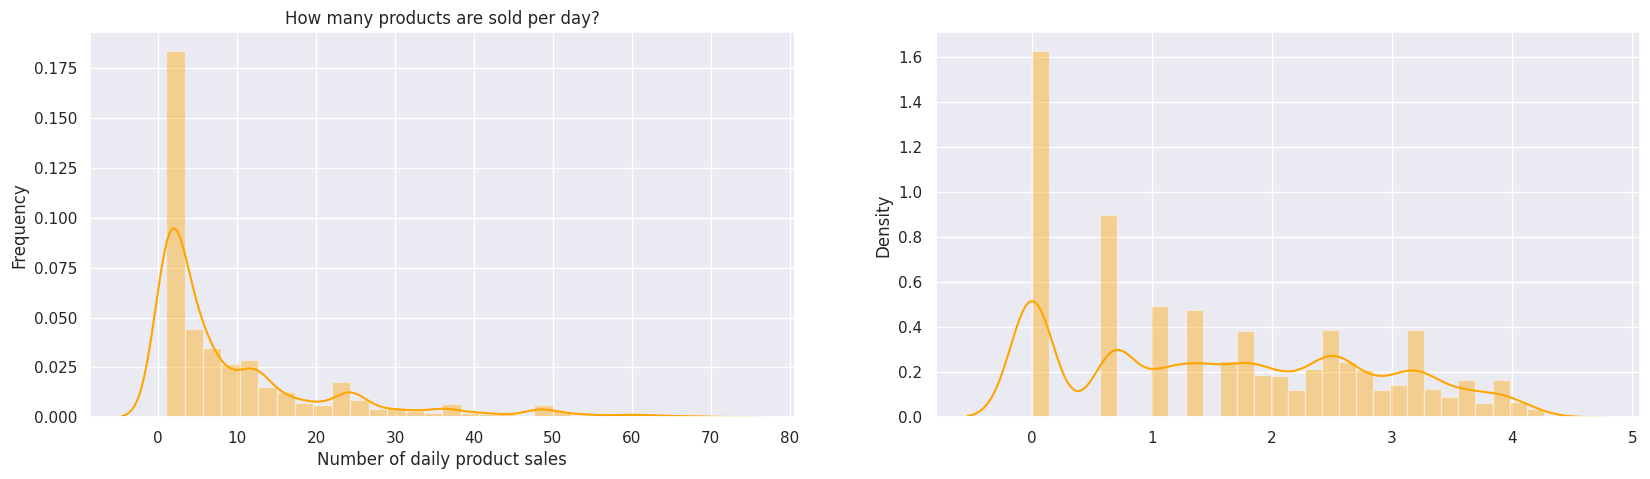

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

- 우측으로 치우친 분포(right skewed) 를 보이며, 낮은 판매량이 훨씬 많이 나타남.

- 다봉분포(multimodal) 형태로, 1개·12개·24개 판매가 특히 흔함.

- 이 패턴은 판매 수량이 2나 3으로 나누어 떨어지는 경우가 많음을 시사.(굿)- 할인 및 묶음 상품 등의 전략으로 이어질 수 있는 인사이트 같음

---
### CatBoost Regressor를 사용한 제품의 일별 판매 수량과 매출(Revenue) 예측

손실 함수 & 평가 지표 – RMSE

$$ E = \sqrt{ \frac{1}{N}\sum_{n=1}^{N} (t_{n} - y_{n})^{2}}$$

1. 예측 오차 계산: 각 샘플의 실제값
t
n
t
n
​
 과 예측값
y
n
y
n
​
 의 차이
2. 제곱: 양수·음수 오차를 동일하게 반영
3. 평균: 전체 샘플 수
N
N으로 나누어 평균 제곱 오차 계산
4. 제곱근: 단일 예측 단위로 해석하기 쉽게 루트를 취함
⚠️ 유의사항: RMSE는 이상치(Outlier)에 매우 민감
→ 소수의 큰 오차가 전체 점수를 크게 끌어올릴 수 있음

---
#### 검증 전략
- 데이터 기간: 1년치, 크리스마스 직전 판매 급증 존재
- 1차 검증: 최소 8주 + 남은 일수를 검증 데이터로 설정
- 최종 전략: 슬라이딩 윈도우 시계열 검증
크리스마스 시즌과 비(非)크리스마스 시즌 모두에서 모델 성능을 평가

---
#### CatBoost & 하이퍼파라미터 클래스

- 목적: 모델을 손쉽게 생성·비교할 수 있도록 주요 설정을 클래스화
- 주요 하이퍼파라미터:

loss_function: 손실 함수 (예: RMSE)

eval_metric: 모델 평가 지표

max_depth: 트리의 최대 깊이

iterations: 부스팅 반복 횟수

l2_leaf_reg: L2 정규화 계수(과적합 방지)

>정리: CatBoost Regressor와 RMSE를 주요 지표로 사용하며, 계절성(특히 크리스마스 시즌) 을 고려한 슬라이딩 윈도우 시계열 검증을 적용한다.
하이퍼파라미터를 클래스 형태로 관리해 모델 실험과 비교를 일관성 있게 수행


In [ ]:
class CatHyperparameter:

    def __init__(self,
                 loss="RMSE",
                 metric="RMSE",
                 iterations=1000,
                 max_depth=4,
                 l2_leaf_reg=3,
                 #learning_rate=0.5,
                 seed=0):
        self.loss = loss,
        self.metric = metric,
        self.max_depth = max_depth,
        self.l2_leaf_reg = l2_leaf_reg,
        #self.learning_rate = learning_rate,
        self.iterations=iterations
        self.seed = seed

### Catmodel 클래스

- CatBoost 모델을 빠르게 실험하고 결과를 시각화하는 간단한 래퍼(wrapper) 클래스
- 입력 데이터:
훈련/검증 Pool 또는 pandas DataFrame 형식의 특징(X) 과 타깃(y)
검증 시작 주(week) : 설정한 첫 번째 검증 주차 이후의 모든 주차 데이터를 검증에 활용

#### 주요 기능
1. 모델 학습(Training)-
지정된 주차 데이터를 기준으로 훈련 데이터와 검증 데이터를 구성 CatBoost 모델을 빠르게 학습시킬 수 있음

2. 학습 과정 시각화-
학습 곡선(learning curve) 등 모델 학습 상태를 실시간으로 확인 가능

3. 특성 중요도(Feature Importance)제공
-학습된 모델에서 각 특징의 중요도를 시각화하여 분석 가능

4. 결과 분석 도구 제공-
예측 결과에 대한 다양한 그래프 및 지표로 모델 성능 평가

In [ ]:
class Catmodel:

    def __init__(self, name, params):
        self.name = name
        self.params = params

    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool

    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != np.float)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(self.x_val, self.y_val, cat_features=cat_features_idx)

    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )

    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot);
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))

    def score(self):
        return self.model.score(self.val_pool)

    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)

    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))

    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax

    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))

    def predict(self, x):
        return self.model.predict(x)

    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )

#### 개요
- 역할: 하이퍼파라미터 최적화를 수행하는 클래스

- 방법: 베이지안 최적화(Bayesian Optimization) + 가우시안 프로세스 회귀(Gaussian Process Regression) 를 활용해 최적 하이퍼파라미터를 탐색.

#### 선택 이유
Catfamily 모델의 점수(Score) 계산에 비용이 많이 드는 경우,

베이지안 최적화는 기존 결과를 기반으로 다음 탐색 지점을 똑똑하게 선택하여 탐색 효율을 높일 수 있음.

#### 주의 사항
베이지안 최적화도 시간이 오래 걸릴 수 있음.
따라서 랜덤 서치(Random Search) 도 함께 시도해보면
더 빠르게 적절한 하이퍼파라미터 후보를 찾을 수 있음.

In [ ]:
import GPyOpt

class Hypertuner:

    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None

    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()

    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.X[np.argmin(optimizer.Y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))

    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model

ModuleNotFoundError: No module named 'GPyOpt'

In [ ]:
%pip install GPyOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.6 MB/s eta 0:00:00
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83602 sha256=aac6e5dc39b30bcb3fe020aa503ebf7766f8f696545236462882ece756a01458
  Stored in directory: /root/.cache/pip/wheels/e8/75/76/e137e5a1b3f42d86877e080683492f6c003f50ad2a73ffb534
Successfully built GPyOpt
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successful

In [ ]:
class CatFamily:

    def __init__(self, params, X, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(X.dtypes != np.float)[0]
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params

    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.X)

    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.X[train_idx], self.X[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool

    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)

    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score

    def score(self):
        return np.mean(self.model_scores)

    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
daily_data.head()

NameError: name 'daily_data' is not defined

In [ ]:
week = daily_data.Week.max() - 2
print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    daily_data[daily_data.Week==week].Date.min()
))

NameError: name 'daily_data' is not defined

In [ ]:
X = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1)
daily_data.Quantity = np.log(daily_data.Quantity)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("baseline", params)
model.set_data(X,y, week)
model.learn(plot=True)

In [ ]:
model.score()

In [ ]:
model.show_val_results();